In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    """
    Represents a language class used for word indexing and counting.

    Args:
        name (str): The name of the language.

    Attributes:
        name (str): The name of the language.
        word2index (dict): A dictionary mapping words to their corresponding indices.
        word2count (dict): A dictionary mapping words to their count in the language.
        index2word (dict): A dictionary mapping indices to their corresponding words.
        n_words (int): The total number of unique words in the language.

    Methods:
        addSentence(sentence): Splits a sentence into words and adds each word to the language.
        addWord(word): Adds a word to the language, updating its index and count if it's new.
    """

    def __init__(self, name):
        self.name = name
        self.word2index = {}  # Dictionary to map words to indices
        self.word2count = {}  # Dictionary to count the occurrences of each word
        self.index2word = {0: "SOS", 1: "EOS"}  # Mapping indices to words, initialized with SOS and EOS tokens
        self.n_words = 2  # Count of unique words, initialized with SOS and EOS

    def addSentence(self, sentence):
        """
        Splits a sentence into words and adds each word to the language.

        Args:
            sentence (str): The input sentence to be processed.
        """
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """
        Adds a word to the language, updating its index and count if it's new.

        Args:
            word (str): The word to be added to the language.
        """
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Turn string into ASCII

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """
    Converts a Unicode string to ASCII.

    Args:
        s (str): The Unicode string to be converted.

    Returns:
        str: The ASCII representation of the input Unicode string.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """
    Lowercases, trims, and removes non-letter characters from a string.

    Args:
        s (str): The input string to be normalized.

    Returns:
        str: The normalized string.
    """
    s = unicodeToAscii(s.lower().strip())  # Convert to ASCII, lowercase, and strip whitespace
    s = re.sub(r"([.!?])", r" \1", s)  # Add space before punctuation marks
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)  # Remove non-letter characters
    return s.strip()  # Trim leading and trailing spaces

## Reading the languages

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    """
    Reads language data from a file and creates language instances.

    Args:
        lang1 (str): The name of the first language.
        lang2 (str): The name of the second language.
        reverse (bool, optional): If True, reverses the language pairs. Defaults to False.

    Returns:
        Tuple[Lang, Lang, List[List[str]]]: A tuple containing two language instances
        and a list of language pairs.
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/eng-fra.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    """
    Determines whether a pair of sentences meets the maximum length constraint and starts with an English prefix.

    Args:
        p (Tuple[str, str]): A pair of sentences (source and target).

    Returns:
        bool: True if the pair meets the criteria, False otherwise.
    """
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    """
    Filters pairs of sentences based on length and English prefixes.

    Args:
        pairs (List[Tuple[str, str]]): A list of sentence pairs (source and target).

    Returns:
        List[Tuple[str, str]]: Filtered list of sentence pairs.
    """
    return [pair for pair in pairs if filterPair(pair)]


# Prepare the data

# ENGLISH-FRENCH

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    """
    Prepares the data for language translation by reading sentence pairs,
    filtering them based on length and prefixes, counting words, and creating language instances.

    Args:
        lang1 (str): The language code of the source language.
        lang2 (str): The language code of the target language.
        reverse (bool, optional): Flag to reverse the order of language pairs. Defaults to False.

    Returns:
        Tuple: A tuple containing input and output language instances, and filtered sentence pairs.
    """
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra')

# print("Input language word2index:")
# print(input_lang.word2index)

# print("\nOutput language word2index:")
# print(output_lang.word2index)

print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
['he s been drinking beer', 'il a ete boire une biere']


## GRU

## Encoder

In [ ]:
class EncoderRNN(nn.Module):
    """
    Encoder RNN module for sequence-to-sequence models.

    Args:
        input_size (int): The size of the input vocabulary.
        hidden_size (int): The size of the hidden state.
        dropout_p (float, optional): Dropout probability. Defaults to 0.1.
    """
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)

        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        """
        Forward pass of the Encoder RNN.

        Args:
            input (torch.Tensor): Input tensor of shape (batch_size, seq_len).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, hidden_size).
            torch.Tensor: Hidden state tensor of shape (1, batch_size, hidden_size).
        """
        # Embed input
        embedded = self.dropout(self.embedding(input))

        # Forward pass through GRU
        output, hidden = self.gru(embedded)

        return output, hidden

## Decoder

In [ ]:
class DecoderRNN(nn.Module):
    """
    Decoder RNN module for sequence-to-sequence models.

    Args:
        hidden_size (int): The size of the hidden state.
        output_size (int): The size of the output vocabulary.
    """
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        """
        Forward pass of the Decoder RNN.

        Args:
            encoder_outputs (torch.Tensor): Tensor containing the output features from the encoder.
            encoder_hidden (torch.Tensor): Tensor containing the hidden state of the encoder.
            target_tensor (torch.Tensor, optional): Tensor containing the target sequence. Defaults to None.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, output_size).
            torch.Tensor: Hidden state tensor of shape (1, batch_size, hidden_size).
            None: Placeholder for consistency in the training loop.
        """
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        """
        Forward step of the Decoder RNN.

        Args:
            input (torch.Tensor): Tensor containing the input sequence.
            hidden (torch.Tensor): Tensor containing the hidden state.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, hidden_size).
            torch.Tensor: Hidden state tensor of shape (1, batch_size, hidden_size).
        """
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

## Attention

In [ ]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism.

    Args:
        hidden_size (int): The size of the hidden state.
    """
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        """
        Forward pass of the Bahdanau Attention mechanism.

        Args:
            query (torch.Tensor): Query tensor.
            keys (torch.Tensor): Keys tensor.

        Returns:
            torch.Tensor: Context tensor.
            torch.Tensor: Attention weights.
        """
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    """
    Decoder RNN with Bahdanau Attention mechanism.

    Args:
        hidden_size (int): The size of the hidden state.
        output_size (int): The size of the output vocabulary.
        dropout_p (float, optional): Dropout probability. Defaults to 0.1.
    """
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        """
        Forward pass of the AttnDecoderRNN.

        Args:
            encoder_outputs (torch.Tensor): Encoder outputs.
            encoder_hidden (torch.Tensor): Encoder hidden state.
            target_tensor (torch.Tensor, optional): Target tensor. Defaults to None.

        Returns:
            torch.Tensor: Decoder outputs.
            torch.Tensor: Decoder hidden state.
            torch.Tensor: Attention weights.
        """
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        """
        Forward step of the AttnDecoderRNN.

        Args:
            input (torch.Tensor): Input tensor.
            hidden (torch.Tensor): Hidden state tensor.
            encoder_outputs (torch.Tensor): Encoder outputs tensor.

        Returns:
            torch.Tensor: Output tensor.
            torch.Tensor: Hidden state tensor.
            torch.Tensor: Attention weights tensor.
        """
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
def indexesFromSentence(lang, sentence):
    """
    Convert a sentence to a list of its corresponding token indexes.

    Args:
        lang (Lang): Language object containing word-to-index mapping.
        sentence (str): Input sentence.

    Returns:
        List[int]: List of token indexes.
    """
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    """
    Convert a sentence to a tensor with token indexes and EOS token.

    Args:
        lang (Lang): Language object containing word-to-index mapping.
        sentence (str): Input sentence.

    Returns:
        torch.Tensor: Tensor of token indexes with EOS token.
    """
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    """
    Generate input and target tensors from a pair of sentences.

    Args:
        pair (tuple): Pair of input and target sentences.

    Returns:
        tuple: Input and target tensors.
    """
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    """
    Generate a DataLoader for training data.

    Args:
        batch_size (int): Batch size for DataLoader.

    Returns:
        tuple: Input language, output language, and DataLoader.
    """
    input_lang, output_lang, pairs = prepareData('eng', 'fra')

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    return input_lang, output_lang, train_dataloader

### Encoder-Decoder Model Training

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    """
    Train one epoch of the sequence-to-sequence model.

    Args:
        dataloader (DataLoader): DataLoader for training data.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        encoder_optimizer (torch.optim.Optimizer): Optimizer for the encoder.
        decoder_optimizer (torch.optim.Optimizer): Optimizer for the decoder.
        criterion (torch.nn.Module): Loss criterion.

    Returns:
        float: Average loss over the epoch.
    """
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    """
    Convert seconds to minutes and seconds.

    Args:
        s (float): Time in seconds.

    Returns:
        str: Time formatted as minutes and seconds.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """
    Calculate the elapsed time since a given time and estimate remaining time.

    Args:
        since (float): The start time.
        percent (float): The completion percentage.

    Returns:
        str: Elapsed time and estimated remaining time.
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    """
    Plot the given points and set major tick locators at regular intervals.

    Args:
        points (array_like): The data points to plot.

    Returns:
        None
    """
    plt.figure()
    fig, ax = plt.subplots()

    # Define the tick locator to put ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    # Plot the points
    plt.plot(points)
    plt.show()

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    """
    Train the encoder-decoder model for a specified number of epochs.

    Args:
        train_dataloader (DataLoader): DataLoader for the training dataset.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n_epochs (int): Number of epochs for training.
        learning_rate (float, optional): Learning rate for the optimizer. Default is 0.001.
        print_every (int, optional): Frequency of printing training progress. Default is 100.
        plot_every (int, optional): Frequency of plotting losses. Default is 100.

    Returns:
        None
    """
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """
    Evaluate the encoder-decoder model on a single sentence.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        sentence (str): Input sentence to be translated.
        input_lang (Lang): Input language object containing word-to-index and index-to-word mappings.
        output_lang (Lang): Output language object containing word-to-index and index-to-word mappings.

    Returns:
        Tuple[List[str], Tensor]: A tuple containing the list of decoded words and the decoder attention.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)  # Convert input sentence to tensor

        # Encode input sentence
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Decode using the encoder outputs and hidden state
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the index of the highest probability output token for each timestep
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:  # If end of sentence token, append '<EOS>' and break
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])  # Append the decoded word
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Evaluate the encoder-decoder model on random input-output pairs.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n (int): Number of pairs to evaluate. Defaults to 10.
    """
    for i in range(n):
        pair = random.choice(pairs)  # Choose a random pair from the dataset
        print('>', pair[0])  # Print the input sequence
        print('=', pair[1])  # Print the target output sequence
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)  # Evaluate the pair
        output_sentence = ' '.join(output_words)  # Convert the list of output words to a sentence
        print('<', output_sentence)  # Print the generated output sequence
        print('')  # Print an empty line for clarity

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Evaluate the encoder-decoder model on random input-output pairs.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n (int): Number of pairs to evaluate. Defaults to 10.
    """
    total_correct = 0
    total_words = 0

    for i in range(n):
        pair = random.choice(pairs)  # Choose a random pair from the dataset
        print('>', pair[0])  # Print the input sequence
        print('=', pair[1])  # Print the target output sequence
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)  # Evaluate the pair
        output_sentence = ' '.join(output_words)  # Convert the list of output words to a sentence
        print('<', output_sentence)  # Print the generated output sequence

        # Calculate accuracy
        target_words = pair[1].split()
        correct = sum(1 for pred, target in zip(output_words, target_words) if pred == target)
        total_correct += correct
        total_words += len(target_words)

        print('Accuracy for this pair:', correct / len(target_words))  # Print accuracy for this pair
        print('')  # Print an empty line for clarity

    print('Overall accuracy:', total_correct / total_words)  # Print overall accuracy

### Encoder-Decoder Model

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
3m 35s (- 10m 47s) (5 25%) 2.0447
7m 3s (- 7m 3s) (10 50%) 1.1028
10m 28s (- 3m 29s) (15 75%) 0.7320
13m 54s (- 0m 0s) (20 100%) 0.5182


<Figure size 640x480 with 0 Axes>

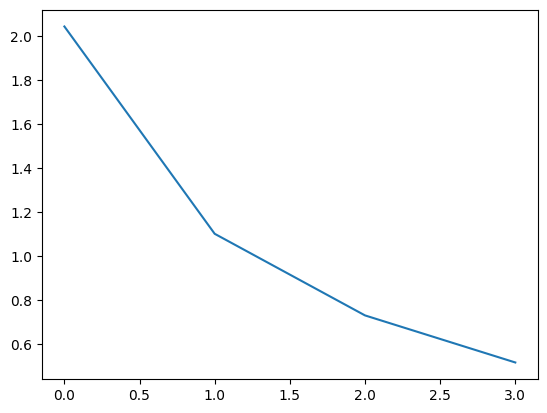

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> i m looking forward to the return of spring
= j attends avec impatience le retour du printemps
< j attends avec impatience le programme du printemps <EOS>
Accuracy for this pair: 0.875

> we re here early
= nous sommes la tot
< nous sommes la tot avec mon ami <EOS>
Accuracy for this pair: 1.0

> i m letting you go
= je vous laisse partir
< je te suis tellement reconnaissant pour votre aide <EOS>
Accuracy for this pair: 0.25

> they re in the shower
= ils sont dans la douche
< elles sont dans le laboratoire de sciences <EOS>
Accuracy for this pair: 0.4

> he is watching my every move
= il observe mon moindre mouvement
< il a etre la tete qui tourne <EOS>
Accuracy for this pair: 0.2

> you re in the right place
= tu es au bon endroit
< tu es responsable de ce que j ai <EOS>
Accuracy for this pair: 0.4

> you re very open
= vous etes tres ouvert
< vous etes tres religieuse ces droit a voyager <EOS>
Accuracy for this pair: 0.75

> you re not alone anymore
= vous n etes plus seule
< vous 

In [ ]:
import numpy as np

def calculate_accuracy(predictions, targets):
    """
    Function to calculate accuracy.
    """
    return np.mean(np.array(predictions) == np.array(targets))

def evaluate_accuracy(encoder, decoder, dataloader, input_lang, output_lang):
    """
    Function to evaluate accuracy on a dataset.
    """
    predictions = []
    targets = []

    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            for idx_tensor, target_tensor in zip(decoded_ids, target_tensor.squeeze()):
                for idx in idx_tensor:
                    idx = idx.item()  # Convert tensor element to scalar
                    if idx == EOS_token:
                        predictions.append('<EOS>')
                    else:
                        predictions.append(output_lang.index2word[idx])


                for target_idx in target_tensor:
                    target = target_idx.item()  # Convert tensor element to scalar
                    if target == EOS_token:
                        targets.append('<EOS>')
                    else:
                        targets.append(output_lang.index2word[target])

    return calculate_accuracy(predictions, targets)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    predictions = []
    targets = []

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        for idx, target_idx in zip(decoded_ids, target_tensor.squeeze()):
            if idx.item() == EOS_token:
                predictions.append('<EOS>')
            else:
                predictions.append(output_lang.index2word[idx.item()])

            if target_idx.item() == EOS_token:
                targets.append('<EOS>')
            else:
                targets.append(output_lang.index2word[target_idx.item()])

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    accuracy = calculate_accuracy(predictions, targets)
    return total_loss / len(dataloader), accuracy

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
            print("Training Accuracy: %.4f" % accuracy)

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Evaluate training accuracy
train_accuracy = evaluate_accuracy(encoder, decoder, train_dataloader, input_lang, output_lang)
print("Final Training Accuracy without Attention: %.4f" % train_accuracy)

Final Training Accuracy without Attention: 0.8981


### Attention Model Training

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    """
    Train one epoch of the sequence-to-sequence model.

    Args:
        dataloader (DataLoader): DataLoader for training data.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        encoder_optimizer (torch.optim.Optimizer): Optimizer for the encoder.
        decoder_optimizer (torch.optim.Optimizer): Optimizer for the decoder.
        criterion (torch.nn.Module): Loss criterion.

    Returns:
        float: Average loss over the epoch.
    """
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    """
    Convert seconds to minutes and seconds.

    Args:
        s (float): Time in seconds.

    Returns:
        str: Time formatted as minutes and seconds.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """
    Calculate the elapsed time since a given time and estimate remaining time.

    Args:
        since (float): The start time.
        percent (float): The completion percentage.

    Returns:
        str: Elapsed time and estimated remaining time.
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    """
    Plot the given points and set major tick locators at regular intervals.

    Args:
        points (array_like): The data points to plot.

    Returns:
        None
    """
    plt.figure()
    fig, ax = plt.subplots()

    # Define the tick locator to put ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    # Plot the points
    plt.plot(points)
    plt.show()

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    """
    Train the encoder-decoder model for a specified number of epochs.

    Args:
        train_dataloader (DataLoader): DataLoader for the training dataset.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n_epochs (int): Number of epochs for training.
        learning_rate (float, optional): Learning rate for the optimizer. Default is 0.001.
        print_every (int, optional): Frequency of printing training progress. Default is 100.
        plot_every (int, optional): Frequency of plotting losses. Default is 100.

    Returns:
        None
    """
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """
    Evaluate the encoder-decoder model on a single sentence.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        sentence (str): Input sentence to be translated.
        input_lang (Lang): Input language object containing word-to-index and index-to-word mappings.
        output_lang (Lang): Output language object containing word-to-index and index-to-word mappings.

    Returns:
        Tuple[List[str], Tensor]: A tuple containing the list of decoded words and the decoder attention.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)  # Convert input sentence to tensor

        # Encode input sentence
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Decode using the encoder outputs and hidden state
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the index of the highest probability output token for each timestep
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:  # If end of sentence token, append '<EOS>' and break
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])  # Append the decoded word
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Evaluate the encoder-decoder model on random input-output pairs.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n (int): Number of pairs to evaluate. Defaults to 10.
    """
    total_correct = 0
    total_words = 0

    for i in range(n):
        pair = random.choice(pairs)  # Choose a random pair from the dataset
        print('>', pair[0])  # Print the input sequence
        print('=', pair[1])  # Print the target output sequence
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)  # Evaluate the pair
        output_sentence = ' '.join(output_words)  # Convert the list of output words to a sentence
        print('<', output_sentence)  # Print the generated output sequence

        # Calculate accuracy
        target_words = pair[1].split()
        correct = sum(1 for pred, target in zip(output_words, target_words) if pred == target)
        total_correct += correct
        total_words += len(target_words)

        print('Accuracy for this pair:', correct / len(target_words))  # Print accuracy for this pair
        print('')  # Print an empty line for clarity

    print('Overall accuracy:', total_correct / total_words)  # Print overall accuracy

## Attention Model

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
4m 26s (- 13m 19s) (5 25%) 1.8641
8m 45s (- 8m 45s) (10 50%) 0.8642
12m 57s (- 4m 19s) (15 75%) 0.4940
17m 11s (- 0m 0s) (20 100%) 0.3204


<Figure size 640x480 with 0 Axes>

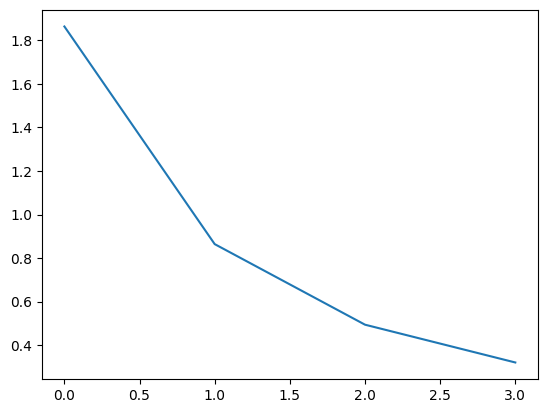

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> you are so childish sometimes
= vous etes parfois si pueriles
< tu es parfois si puerile <EOS>
Accuracy for this pair: 0.4

> you re my kid s teacher
= vous etes l institutrice de mon enfant
< vous etes l institutrice de mon enfant <EOS>
Accuracy for this pair: 1.0

> i m always careful
= je suis toujours prudente
< je suis toujours faim <EOS>
Accuracy for this pair: 0.75

> i m your sister
= je suis ta s ur
< je suis votre s ur <EOS>
Accuracy for this pair: 0.8

> i m really glad i ran into you
= je suis vraiment content d etre tombe sur toi
< je suis vraiment content de vous avoir fait attendre <EOS>
Accuracy for this pair: 0.4444444444444444

> he is unable to buy a car
= il est incapable d acheter une voiture
< il est incapable d acheter une voiture <EOS>
Accuracy for this pair: 1.0

> i m sure
= j en suis sur
< je suis sure que moi <EOS>
Accuracy for this pair: 0.0

> we re in love
= nous nous aimons
< nous sommes amoureuses <EOS>
Accuracy for this pair: 0.3333333333333333

> yo

In [ ]:
import numpy as np

def calculate_accuracy(predictions, targets):
    """
    Function to calculate accuracy.
    """
    return np.mean(np.array(predictions) == np.array(targets))

def evaluate_accuracy(encoder, decoder, dataloader, input_lang, output_lang):
    """
    Function to evaluate accuracy on a dataset.
    """
    predictions = []
    targets = []

    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            for idx_tensor, target_tensor in zip(decoded_ids, target_tensor.squeeze()):
                for idx in idx_tensor:
                    idx = idx.item()  # Convert tensor element to scalar
                    if idx == EOS_token:
                        predictions.append('<EOS>')
                    else:
                        predictions.append(output_lang.index2word[idx])


                for target_idx in target_tensor:
                    target = target_idx.item()  # Convert tensor element to scalar
                    if target == EOS_token:
                        targets.append('<EOS>')
                    else:
                        targets.append(output_lang.index2word[target])

    return calculate_accuracy(predictions, targets)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    predictions = []
    targets = []

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        for idx, target_idx in zip(decoded_ids, target_tensor.squeeze()):
            if idx.item() == EOS_token:
                predictions.append('<EOS>')
            else:
                predictions.append(output_lang.index2word[idx.item()])

            if target_idx.item() == EOS_token:
                targets.append('<EOS>')
            else:
                targets.append(output_lang.index2word[target_idx.item()])

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    accuracy = calculate_accuracy(predictions, targets)
    return total_loss / len(dataloader), accuracy

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
            print("Training Accuracy: %.4f" % accuracy)

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Evaluate training accuracy
train_accuracy = evaluate_accuracy(encoder, decoder, train_dataloader, input_lang, output_lang)
print("Final Training Accuracy with Attention Model: %.4f" % train_accuracy)

Final Training Accuracy with Attention Model: 0.9365


# Prepare the data

# FRENCH-ENGLISH

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    """
    Represents a language class used for word indexing and counting.

    Args:
        name (str): The name of the language.

    Attributes:
        name (str): The name of the language.
        word2index (dict): A dictionary mapping words to their corresponding indices.
        word2count (dict): A dictionary mapping words to their count in the language.
        index2word (dict): A dictionary mapping indices to their corresponding words.
        n_words (int): The total number of unique words in the language.

    Methods:
        addSentence(sentence): Splits a sentence into words and adds each word to the language.
        addWord(word): Adds a word to the language, updating its index and count if it's new.
    """

    def __init__(self, name):
        self.name = name
        self.word2index = {}  # Dictionary to map words to indices
        self.word2count = {}  # Dictionary to count the occurrences of each word
        self.index2word = {0: "SOS", 1: "EOS"}  # Mapping indices to words, initialized with SOS and EOS tokens
        self.n_words = 2  # Count of unique words, initialized with SOS and EOS

    def addSentence(self, sentence):
        """
        Splits a sentence into words and adds each word to the language.

        Args:
            sentence (str): The input sentence to be processed.
        """
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """
        Adds a word to the language, updating its index and count if it's new.

        Args:
            word (str): The word to be added to the language.
        """
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """
    Converts a Unicode string to ASCII.

    Args:
        s (str): The Unicode string to be converted.

    Returns:
        str: The ASCII representation of the input Unicode string.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """
    Lowercases, trims, and removes non-letter characters from a string.

    Args:
        s (str): The input string to be normalized.

    Returns:
        str: The normalized string.
    """
    s = unicodeToAscii(s.lower().strip())  # Convert to ASCII, lowercase, and strip whitespace
    s = re.sub(r"([.!?])", r" \1", s)  # Add space before punctuation marks
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)  # Remove non-letter characters
    return s.strip()  # Trim leading and trailing spaces

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    """
    Reads language data from a file and creates language instances.

    Args:
        lang1 (str): The name of the first language.
        lang2 (str): The name of the second language.
        reverse (bool, optional): If True, reverses the language pairs. Defaults to False.

    Returns:
        Tuple[Lang, Lang, List[List[str]]]: A tuple containing two language instances
        and a list of language pairs.
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/eng-fra.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    """
    Determines whether a pair of sentences meets the maximum length constraint and starts with an English prefix.

    Args:
        p (Tuple[str, str]): A pair of sentences (source and target).

    Returns:
        bool: True if the pair meets the criteria, False otherwise.
    """
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    """
    Filters pairs of sentences based on length and English prefixes.

    Args:
        pairs (List[Tuple[str, str]]): A list of sentence pairs (source and target).

    Returns:
        List[Tuple[str, str]]: Filtered list of sentence pairs.
    """
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    """
    Prepares the data for language translation by reading sentence pairs,
    filtering them based on length and prefixes, counting words, and creating language instances.

    Args:
        lang1 (str): The language code of the source language.
        lang2 (str): The language code of the target language.
        reverse (bool, optional): Flag to reverse the order of language pairs. Defaults to False.

    Returns:
        Tuple: A tuple containing input and output language instances, and filtered sentence pairs.
    """
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['je suis etudiant a l universite', 'i am a university student']


### Encoder

In [ ]:
class EncoderRNN(nn.Module):
    """
    Encoder RNN module for sequence-to-sequence models.

    Args:
        input_size (int): The size of the input vocabulary.
        hidden_size (int): The size of the hidden state.
        dropout_p (float, optional): Dropout probability. Defaults to 0.1.
    """
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)

        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        """
        Forward pass of the Encoder RNN.

        Args:
            input (torch.Tensor): Input tensor of shape (batch_size, seq_len).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, hidden_size).
            torch.Tensor: Hidden state tensor of shape (1, batch_size, hidden_size).
        """
        # Embed input
        embedded = self.dropout(self.embedding(input))

        # Forward pass through GRU
        output, hidden = self.gru(embedded)

        return output, hidden

### Decoder

In [ ]:
class DecoderRNN(nn.Module):
    """
    Decoder RNN module for sequence-to-sequence models.

    Args:
        hidden_size (int): The size of the hidden state.
        output_size (int): The size of the output vocabulary.
    """
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        """
        Forward pass of the Decoder RNN.

        Args:
            encoder_outputs (torch.Tensor): Tensor containing the output features from the encoder.
            encoder_hidden (torch.Tensor): Tensor containing the hidden state of the encoder.
            target_tensor (torch.Tensor, optional): Tensor containing the target sequence. Defaults to None.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, output_size).
            torch.Tensor: Hidden state tensor of shape (1, batch_size, hidden_size).
            None: Placeholder for consistency in the training loop.
        """
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        """
        Forward step of the Decoder RNN.

        Args:
            input (torch.Tensor): Tensor containing the input sequence.
            hidden (torch.Tensor): Tensor containing the hidden state.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, hidden_size).
            torch.Tensor: Hidden state tensor of shape (1, batch_size, hidden_size).
        """
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Attention

In [ ]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism.

    Args:
        hidden_size (int): The size of the hidden state.
    """
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        """
        Forward pass of the Bahdanau Attention mechanism.

        Args:
            query (torch.Tensor): Query tensor.
            keys (torch.Tensor): Keys tensor.

        Returns:
            torch.Tensor: Context tensor.
            torch.Tensor: Attention weights.
        """
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    """
    Decoder RNN with Bahdanau Attention mechanism.

    Args:
        hidden_size (int): The size of the hidden state.
        output_size (int): The size of the output vocabulary.
        dropout_p (float, optional): Dropout probability. Defaults to 0.1.
    """
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        """
        Forward pass of the AttnDecoderRNN.

        Args:
            encoder_outputs (torch.Tensor): Encoder outputs.
            encoder_hidden (torch.Tensor): Encoder hidden state.
            target_tensor (torch.Tensor, optional): Target tensor. Defaults to None.

        Returns:
            torch.Tensor: Decoder outputs.
            torch.Tensor: Decoder hidden state.
            torch.Tensor: Attention weights.
        """
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        """
        Forward step of the AttnDecoderRNN.

        Args:
            input (torch.Tensor): Input tensor.
            hidden (torch.Tensor): Hidden state tensor.
            encoder_outputs (torch.Tensor): Encoder outputs tensor.

        Returns:
            torch.Tensor: Output tensor.
            torch.Tensor: Hidden state tensor.
            torch.Tensor: Attention weights tensor.
        """
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Load the model

In [ ]:
def indexesFromSentence(lang, sentence):
    """
    Convert a sentence to a list of its corresponding token indexes.

    Args:
        lang (Lang): Language object containing word-to-index mapping.
        sentence (str): Input sentence.

    Returns:
        List[int]: List of token indexes.
    """
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    """
    Convert a sentence to a tensor with token indexes and EOS token.

    Args:
        lang (Lang): Language object containing word-to-index mapping.
        sentence (str): Input sentence.

    Returns:
        torch.Tensor: Tensor of token indexes with EOS token.
    """
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    """
    Generate input and target tensors from a pair of sentences.

    Args:
        pair (tuple): Pair of input and target sentences.

    Returns:
        tuple: Input and target tensors.
    """
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    """
    Generate a DataLoader for training data.

    Args:
        batch_size (int): Batch size for DataLoader.

    Returns:
        tuple: Input language, output language, and DataLoader.
    """
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    return input_lang, output_lang, train_dataloader

### Encoder-Decoder Model Training

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    """
    Train one epoch of the sequence-to-sequence model.

    Args:
        dataloader (DataLoader): DataLoader for training data.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        encoder_optimizer (torch.optim.Optimizer): Optimizer for the encoder.
        decoder_optimizer (torch.optim.Optimizer): Optimizer for the decoder.
        criterion (torch.nn.Module): Loss criterion.

    Returns:
        float: Average loss over the epoch.
    """
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    """
    Convert seconds to minutes and seconds.

    Args:
        s (float): Time in seconds.

    Returns:
        str: Time formatted as minutes and seconds.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """
    Calculate the elapsed time since a given time and estimate remaining time.

    Args:
        since (float): The start time.
        percent (float): The completion percentage.

    Returns:
        str: Elapsed time and estimated remaining time.
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    """
    Plot the given points and set major tick locators at regular intervals.

    Args:
        points (array_like): The data points to plot.

    Returns:
        None
    """
    plt.figure()
    fig, ax = plt.subplots()

    # Define the tick locator to put ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    # Plot the points
    plt.plot(points)
    plt.show()

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    """
    Train the encoder-decoder model for a specified number of epochs.

    Args:
        train_dataloader (DataLoader): DataLoader for the training dataset.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n_epochs (int): Number of epochs for training.
        learning_rate (float, optional): Learning rate for the optimizer. Default is 0.001.
        print_every (int, optional): Frequency of printing training progress. Default is 100.
        plot_every (int, optional): Frequency of plotting losses. Default is 100.

    Returns:
        None
    """
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """
    Evaluate the encoder-decoder model on a single sentence.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        sentence (str): Input sentence to be translated.
        input_lang (Lang): Input language object containing word-to-index and index-to-word mappings.
        output_lang (Lang): Output language object containing word-to-index and index-to-word mappings.

    Returns:
        Tuple[List[str], Tensor]: A tuple containing the list of decoded words and the decoder attention.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)  # Convert input sentence to tensor

        # Encode input sentence
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Decode using the encoder outputs and hidden state
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the index of the highest probability output token for each timestep
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:  # If end of sentence token, append '<EOS>' and break
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])  # Append the decoded word
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Evaluate the encoder-decoder model on random input-output pairs.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n (int): Number of pairs to evaluate. Defaults to 10.
    """
    total_correct = 0
    total_words = 0

    for i in range(n):
        pair = random.choice(pairs)  # Choose a random pair from the dataset
        print('>', pair[0])  # Print the input sequence
        print('=', pair[1])  # Print the target output sequence
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)  # Evaluate the pair
        output_sentence = ' '.join(output_words)  # Convert the list of output words to a sentence
        print('<', output_sentence)  # Print the generated output sequence

        # Calculate accuracy
        target_words = pair[1].split()
        correct = sum(1 for pred, target in zip(output_words, target_words) if pred == target)
        total_correct += correct
        total_words += len(target_words)

        print('Accuracy for this pair:', correct / len(target_words))  # Print accuracy for this pair
        print('')  # Print an empty line for clarity

    print('Overall accuracy:', total_correct / total_words)  # Print overall accuracy

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
2m 41s (- 8m 5s) (5 25%) 1.7350
5m 25s (- 5m 25s) (10 50%) 0.9750
8m 6s (- 2m 42s) (15 75%) 0.6676
10m 46s (- 0m 0s) (20 100%) 0.4789


<Figure size 640x480 with 0 Axes>

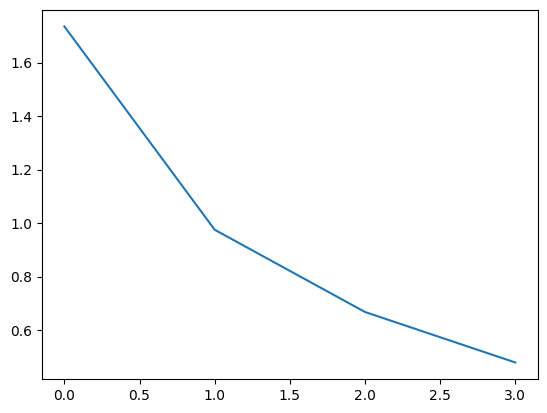

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> il n est pas idiot
= he s not stupid
< he isn t really not interested in history <EOS>
Accuracy for this pair: 0.25

> ma vie pour une biere !
= i m dying for a beer !
< i m getting a little dizzy <EOS>
Accuracy for this pair: 0.2857142857142857

> vous etes toujours vivant
= you re still alive
< you re always finding fault with me <EOS>
Accuracy for this pair: 0.5

> je suis un electricien
= i am an electrician
< i m a stranger here for your advice <EOS>
Accuracy for this pair: 0.25

> elles n ont pas toujours raison
= they re not always right
< they re not always right <EOS>
Accuracy for this pair: 1.0

> tu es grand
= you re big
< you re very clever here <EOS>
Accuracy for this pair: 0.6666666666666666

> je suis impatient de te revoir
= i am looking forward to seeing you again
< i m glad that makes you happy <EOS>
Accuracy for this pair: 0.125

> elle est toujours soignee et ordonnee
= she is always neat and tidy
< she is always finding fault with others <EOS>
Accuracy for this p

In [ ]:
import numpy as np

def calculate_accuracy(predictions, targets):
    """
    Function to calculate accuracy.
    """
    return np.mean(np.array(predictions) == np.array(targets))

def evaluate_accuracy(encoder, decoder, dataloader, input_lang, output_lang):
    """
    Function to evaluate accuracy on a dataset.
    """
    predictions = []
    targets = []

    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            for idx_tensor, target_tensor in zip(decoded_ids, target_tensor.squeeze()):
                for idx in idx_tensor:
                    idx = idx.item()  # Convert tensor element to scalar
                    if idx == EOS_token:
                        predictions.append('<EOS>')
                    else:
                        predictions.append(output_lang.index2word[idx])


                for target_idx in target_tensor:
                    target = target_idx.item()  # Convert tensor element to scalar
                    if target == EOS_token:
                        targets.append('<EOS>')
                    else:
                        targets.append(output_lang.index2word[target])

    return calculate_accuracy(predictions, targets)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    predictions = []
    targets = []

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        for idx, target_idx in zip(decoded_ids, target_tensor.squeeze()):
            if idx.item() == EOS_token:
                predictions.append('<EOS>')
            else:
                predictions.append(output_lang.index2word[idx.item()])

            if target_idx.item() == EOS_token:
                targets.append('<EOS>')
            else:
                targets.append(output_lang.index2word[target_idx.item()])

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    accuracy = calculate_accuracy(predictions, targets)
    return total_loss / len(dataloader), accuracy

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
            print("Training Accuracy: %.4f" % accuracy)

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Evaluate training accuracy
train_accuracy = evaluate_accuracy(encoder, decoder, train_dataloader, input_lang, output_lang)
print("Final Training Accuracy without Attention: %.4f" % train_accuracy)

Final Training Accuracy without Attention: 0.9152


### Attention Model Training

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    """
    Train one epoch of the sequence-to-sequence model.

    Args:
        dataloader (DataLoader): DataLoader for training data.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        encoder_optimizer (torch.optim.Optimizer): Optimizer for the encoder.
        decoder_optimizer (torch.optim.Optimizer): Optimizer for the decoder.
        criterion (torch.nn.Module): Loss criterion.

    Returns:
        float: Average loss over the epoch.
    """
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    """
    Convert seconds to minutes and seconds.

    Args:
        s (float): Time in seconds.

    Returns:
        str: Time formatted as minutes and seconds.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """
    Calculate the elapsed time since a given time and estimate remaining time.

    Args:
        since (float): The start time.
        percent (float): The completion percentage.

    Returns:
        str: Elapsed time and estimated remaining time.
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    """
    Plot the given points and set major tick locators at regular intervals.

    Args:
        points (array_like): The data points to plot.

    Returns:
        None
    """
    plt.figure()
    fig, ax = plt.subplots()

    # Define the tick locator to put ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    # Plot the points
    plt.plot(points)
    plt.show()

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    """
    Train the encoder-decoder model for a specified number of epochs.

    Args:
        train_dataloader (DataLoader): DataLoader for the training dataset.
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n_epochs (int): Number of epochs for training.
        learning_rate (float, optional): Learning rate for the optimizer. Default is 0.001.
        print_every (int, optional): Frequency of printing training progress. Default is 100.
        plot_every (int, optional): Frequency of plotting losses. Default is 100.

    Returns:
        None
    """
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """
    Evaluate the encoder-decoder model on a single sentence.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        sentence (str): Input sentence to be translated.
        input_lang (Lang): Input language object containing word-to-index and index-to-word mappings.
        output_lang (Lang): Output language object containing word-to-index and index-to-word mappings.

    Returns:
        Tuple[List[str], Tensor]: A tuple containing the list of decoded words and the decoder attention.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)  # Convert input sentence to tensor

        # Encode input sentence
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Decode using the encoder outputs and hidden state
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the index of the highest probability output token for each timestep
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:  # If end of sentence token, append '<EOS>' and break
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])  # Append the decoded word
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Evaluate the encoder-decoder model on random input-output pairs.

    Args:
        encoder (torch.nn.Module): Encoder model.
        decoder (torch.nn.Module): Decoder model.
        n (int): Number of pairs to evaluate. Defaults to 10.
    """
    total_correct = 0
    total_words = 0

    for i in range(n):
        pair = random.choice(pairs)  # Choose a random pair from the dataset
        print('>', pair[0])  # Print the input sequence
        print('=', pair[1])  # Print the target output sequence
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)  # Evaluate the pair
        output_sentence = ' '.join(output_words)  # Convert the list of output words to a sentence
        print('<', output_sentence)  # Print the generated output sequence

        # Calculate accuracy
        target_words = pair[1].split()
        correct = sum(1 for pred, target in zip(output_words, target_words) if pred == target)
        total_correct += correct
        total_words += len(target_words)

        print('Accuracy for this pair:', correct / len(target_words))  # Print accuracy for this pair
        print('')  # Print an empty line for clarity

    print('Overall accuracy:', total_correct / total_words)  # Print overall accuracy

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
3m 30s (- 10m 31s) (5 25%) 1.5247
7m 0s (- 7m 0s) (10 50%) 0.6697
10m 31s (- 3m 30s) (15 75%) 0.3484
14m 2s (- 0m 0s) (20 100%) 0.1955


<Figure size 640x480 with 0 Axes>

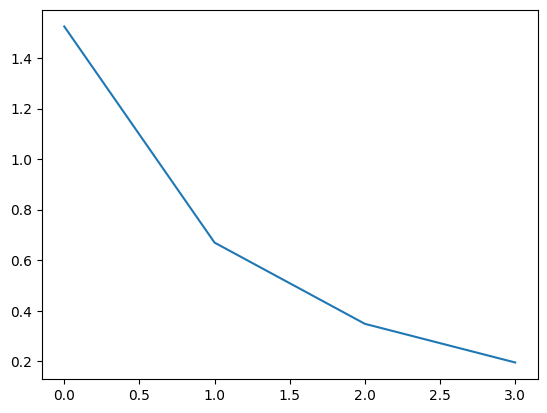

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> vous etes trop lents
= you re too slow
< you re too polite <EOS>
Accuracy for this pair: 0.75

> elle est de nouveau elle meme
= she is her old self again
< she is studying the same age <EOS>
Accuracy for this pair: 0.3333333333333333

> nous connaissons la reussite
= we re successful
< we re successful the same problems <EOS>
Accuracy for this pair: 1.0

> tu es occupe en ce moment ?
= you are busy now aren t you ?
< you are busy now aren t you ? <EOS>
Accuracy for this pair: 1.0

> elles sont trop grosses
= they re too fat
< they re too fat <EOS>
Accuracy for this pair: 1.0

> j ai peur qu elle ait les oreillons
= i m afraid she may have the mumps
< i m afraid she may have the mumps <EOS>
Accuracy for this pair: 1.0

> j ai une faim de loup
= i m very hungry
< i m very hungry <EOS>
Accuracy for this pair: 1.0

> je me vets
= i am getting dressed
< i am getting dressed <EOS>
Accuracy for this pair: 1.0

> j ai peur des chiens
= i m afraid of dogs
< i am afraid of dogs <EOS>
Accuracy

In [ ]:
import numpy as np

def calculate_accuracy(predictions, targets):
    """
    Function to calculate accuracy.
    """
    return np.mean(np.array(predictions) == np.array(targets))

def evaluate_accuracy(encoder, decoder, dataloader, input_lang, output_lang):
    """
    Function to evaluate accuracy on a dataset.
    """
    predictions = []
    targets = []

    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            for idx_tensor, target_tensor in zip(decoded_ids, target_tensor.squeeze()):
                for idx in idx_tensor:
                    idx = idx.item()  # Convert tensor element to scalar
                    if idx == EOS_token:
                        predictions.append('<EOS>')
                    else:
                        predictions.append(output_lang.index2word[idx])


                for target_idx in target_tensor:
                    target = target_idx.item()  # Convert tensor element to scalar
                    if target == EOS_token:
                        targets.append('<EOS>')
                    else:
                        targets.append(output_lang.index2word[target])

    return calculate_accuracy(predictions, targets)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    predictions = []
    targets = []

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        for idx, target_idx in zip(decoded_ids, target_tensor.squeeze()):
            if idx.item() == EOS_token:
                predictions.append('<EOS>')
            else:
                predictions.append(output_lang.index2word[idx.item()])

            if target_idx.item() == EOS_token:
                targets.append('<EOS>')
            else:
                targets.append(output_lang.index2word[target_idx.item()])

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    accuracy = calculate_accuracy(predictions, targets)
    return total_loss / len(dataloader), accuracy

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
            print("Training Accuracy: %.4f" % accuracy)

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Evaluate training accuracy
train_accuracy = evaluate_accuracy(encoder, decoder, train_dataloader, input_lang, output_lang)
print("Final Training Accuracy with Attention: %.4f" % train_accuracy)

Final Training Accuracy with Attention: 0.9768
